# Get Kung Fu Tea locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import json
import pandas as pd
import geopandas as gpd
import urllib.request
import usaddress

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = None

## Read data

#### Get locations from JSON on [store locator page](https://www.kungfutea.com/locations/usa)

In [4]:
with urllib.request.urlopen(
    "https://api.storepoint.co/v1/15dcedfc240d49/locations?rq"
) as url:
    data = json.load(url)

In [5]:
store_list = []

for d in data["results"]["locations"]:
    store_dict = {
        "id": d["id"],
        "address": d.get("streetaddress"),
        "lat": d.get("loc_lat"),
        "long": d.get("loc_long"),
        "phone": d.get("phone"),
        "instagram": d.get("instagram", "")
        .replace("https://www.instagram.com/", "")
        .replace("/", "")
        .replace("0", "")
        if d.get("instagram")
        else "",
    }
    store_list.append(store_dict)

In [6]:
src = pd.DataFrame(store_list)

#### Parse addresses using `usaddress`

In [7]:
src["parsed_address"] = src["address"].apply(lambda x: usaddress.parse(x))

#### Create separate columns dynamically from tuples

In [8]:
for row in src["parsed_address"]:
    for element in row:
        col_name = element[1].replace(",", "")  # Convert to lowercase and remove commas
        if col_name not in src.columns:
            src[col_name] = None  # Initialize the column if it doesn't exist

#### Fill in values

In [9]:
for idx, row in enumerate(src["parsed_address"]):
    for element in row:
        col_name = element[1].replace(",", "")  # Convert to lowercase and remove commas
        src.at[idx, col_name] = element[0]

src.columns = src.columns.str.lower()

#### Clean up addresses

In [10]:
src["streetnameposttype"] = (
    src["streetnameposttype"].str.title().str.replace(",", "", regex=False)
)
src["placename"] = src["placename"].str.title().str.replace(",", "", regex=False)
src["statename"] = (
    src["statename"]
    .str.replace("Alabama", "AL", regex=False)
    .str.replace("Jersey", "NJ", regex=False)
    .str.replace("York", "NY", regex=False)
    .str.replace("Kansas", "KS", regex=False)
    .str.replace("Maryland", "MD", regex=False)
    .str.replace("Georgia", "GA", regex=False)
    .str.replace("Ohio", "OH", regex=False)
    .str.replace(",", "", regex=False)
    .str.upper()
)

#### Clean dataframe

In [11]:
df = src[
    [
        "id",
        "lat",
        "long",
        "phone",
        "instagram",
        "addressnumber",
        "streetname",
        "streetnameposttype",
        "placename",
        "statename",
        "zipcode",
    ]
].copy()

In [12]:
len(df)

425

---

## Geography

#### Read list of story dictionaries into dataframe

In [13]:
geo_df = df.copy()

#### Make a geodataframe from lon/lat

In [14]:
gdf = gpd.GeoDataFrame(
    geo_df, geometry=gpd.points_from_xy(geo_df.long, geo_df.lat)
).set_crs("epsg:4326")

<AxesSubplot: >

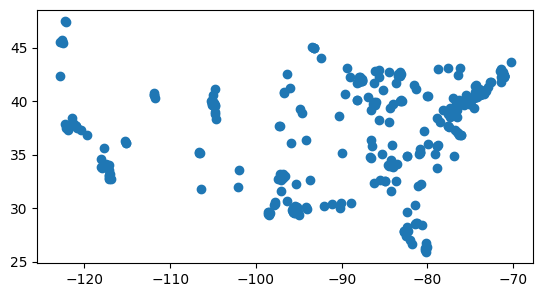

In [15]:
gdf.plot()

---

## Exports

#### CSV

In [16]:
df.to_csv("data/processed/kung_fu_tea_locations.csv", index=False)

#### JSON

In [17]:
df.to_json("data/processed/kung_fu_tea_locations.json", indent=4, orient="records")

#### GeoJSON

In [18]:
gdf.to_file("data/processed/kung_fu_tea_locations.geojson", driver="GeoJSON")